# KMeans clustering applied to Kubernetes cluster

In [70]:
# Define external functions and set figure size
%run influxdb-fetcher.py
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


In [71]:
# Evaluate labels
import ast
fd = open('2018-06-26_12-04-23.labels')
labels_timestamps = ast.literal_eval(file.read(fd))
print labels_timestamps

[[1530014663, 'low'], [1530014686, 'high'], [1530014715, 'high'], [1530014743, 'middle'], [1530014767, 'middle'], [1530014797, 'low'], [1530014820, 'high'], [1530014847, 'low'], [1530014873, 'middle'], [1530014898, 'middle']]


In [72]:
# Get data from database
node_cpu_norm = getInfluxData('192.168.104.186', 'node_cpu_norm')

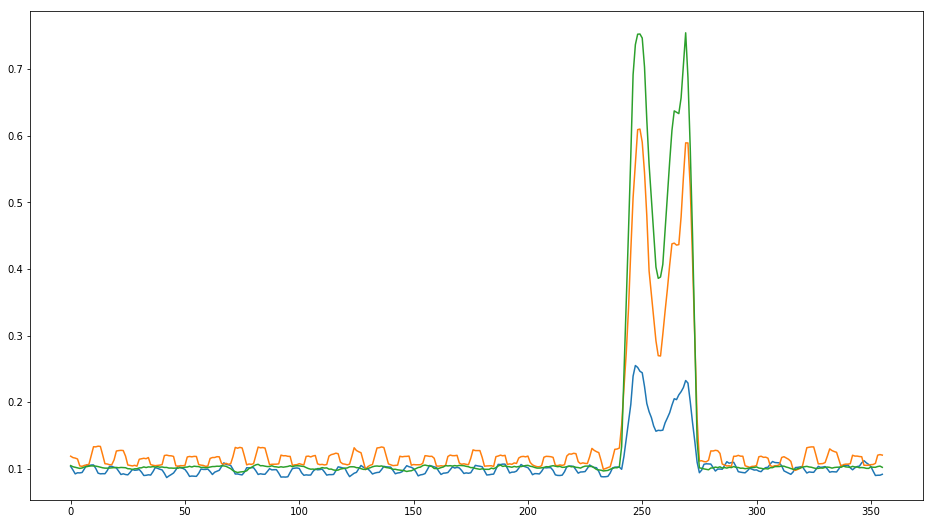

In [73]:
# Plot data from database
import matplotlib.pyplot as plt
import numpy as np
data = np.array(node_cpu_norm)
plt.plot(node_cpu_norm)
plt.show()

k-means++	0.02s	0	1.000	0.000	0.000	0.000	0.000	0.923
random   	0.03s	0	1.000	0.000	0.000	0.000	0.000	0.929
PCA-based	0.00s	0	1.000	0.000	0.000	0.000	0.000	0.391
__________________________________________________________________________________


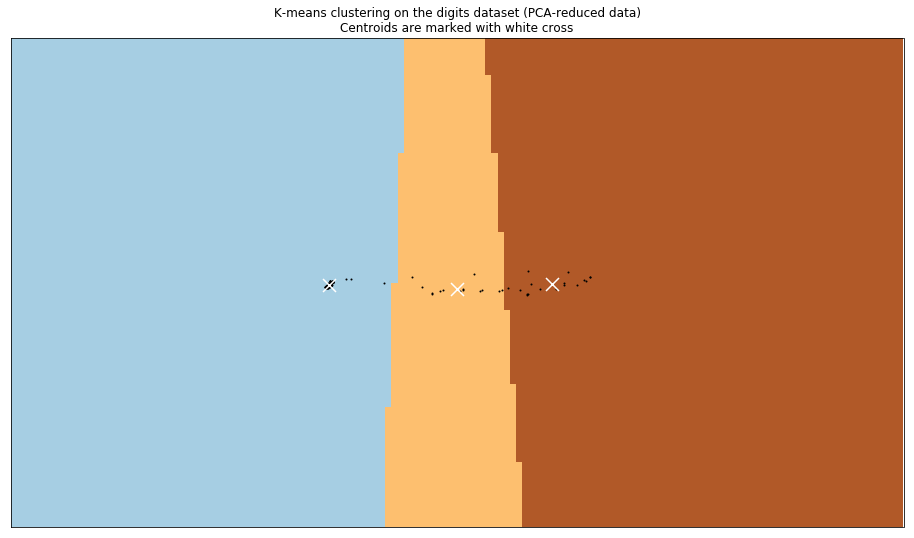

In [74]:
# Apply KMeans clustering and plot the PCA-reduced result
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

# digits = load_digits()
# data = scale(digits.data)

n_samples, n_features = data.shape
#n_digits = len(np.unique(data.target))
#labels = data.target
n_digits = 3;
labels = []
for i in range(0,n_samples):
    labels.append(0);

# sample_size = 300
# print("n_digits: %d, \t n_samples %d, \t n_features %d"
#      % (n_digits, n_samples, n_features))
# print(82 * '_')
# print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()